# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from itertools import product

# Configs

In [2]:
INPUT_PATH = 'data/pair_features.parquet'

OUTPUT_PATH_TEST = 'ridge/pairs_ridge_test_predictions.parquet'
OUTPUT_PATH_TRAIN = 'ridge/pairs_ridge_train_predictions.parquet'

FEATURE_LIST = [
                'day_of_week',
                'day_of_month',

                'max_previous_week_interval',
                'max_previous_7exact_interval',
    
                'previous_day_9interval',
                'previous_day_10interval',
                'previous_day_17interval',
                'previous_day_14interval',
                'previous_day_15interval',
    
                'previous_day_interval',
                'previous_2day_interval',
                'previous_3day_interval',
                'previous_4day_interval',
                'previous_5day_interval',
                'previous_6day_interval',
                'previous_week_interval',
                'previous_8day_interval',
                'previous_9day_interval',
                'previous_10day_interval',
                'previous_11day_interval',
                'previous_12day_interval',
                'previous_13day_interval',
                'previous_2week_interval'
               ]


TEST_START_DATE = '2023-04-1'
VALIDATION_START_DATE = '2023-03-18'

NUM_INTERVAL_PER_DAY = 8

# Data preparation


## Load Data

In [3]:
features_df = pd.read_parquet(INPUT_PATH)
print(f'rfeatures dataframe shape : {features_df.shape}')
features_df.head()

rfeatures dataframe shape : (1385280, 8)


,PULocation,Date,DOLocation,Hour_interval,Demand,previous_day_interval,previous_week_interval,previous_2week_interval
0,13,2023-01-01,68,0,1.0,NaN,NaN,NaN
1,13,2023-01-01,68,3,1.0,NaN,NaN,NaN
2,13,2023-01-01,68,6,2.0,NaN,NaN,NaN
3,13,2023-01-01,68,9,3.0,NaN,NaN,NaN
4,13,2023-01-01,68,12,8.0,NaN,NaN,NaN


## Add feature

In [4]:
def add_feature(dataset, lag_num):
    
    for i in range(1,lag_num):
        if i not in(1,7):
            dataset[f'previous_{i}day_interval'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(i*NUM_INTERVAL_PER_DAY)

    
    dataset['day_of_week'] = dataset['Date'].dt.dayofweek
    dataset['day_of_month'] = dataset['Date'].dt.day

    dataset['max_previous_week_interval'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].rolling(window = 7*NUM_INTERVAL_PER_DAY).max().reset_index(drop=True)
    dataset['max_previous_2week_interval'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].rolling(window = 14*NUM_INTERVAL_PER_DAY).max().reset_index(drop=True)
    
    df = dataset.sort_values(['PULocation', 'DOLocation','Hour_interval','Date'])[['PULocation', 'DOLocation','Hour_interval','Date','Demand']]
    df['max_previous_7exact_interval'] = dataset.groupby(['PULocation', 'DOLocation','Hour_interval'])['Demand'].rolling(window = 7).max().values
    dataset['max_previous_7exact_interval'] = df.sort_values(['PULocation', 'DOLocation', 'Date','Hour_interval'])['max_previous_7exact_interval']
    df['max_previous_14exact_interval'] = dataset.groupby(['PULocation', 'DOLocation','Hour_interval'])['Demand'].rolling(window = 14).max().values
    dataset['max_previous_14exact_interval'] = df.sort_values(['PULocation', 'DOLocation', 'Date','Hour_interval'])['max_previous_14exact_interval']

    dataset['previous_day_9interval'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(NUM_INTERVAL_PER_DAY+1)
    dataset['previous_day_10interval'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(NUM_INTERVAL_PER_DAY+2)
    dataset['previous_day_14interval'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(NUM_INTERVAL_PER_DAY+6)
    dataset['previous_day_15interval'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(NUM_INTERVAL_PER_DAY+7)
    dataset['previous_day_17interval'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(NUM_INTERVAL_PER_DAY+9)
    
    return dataset


In [5]:
new_features_df = add_feature(features_df, lag_num = 14)
print(f'new features dataframe shape : {new_features_df.shape}')
new_features_df.head()

new features dataframe shape : (1385280, 30)


,PULocation,Date,DOLocation,Hour_interval,Demand,previous_day_interval,previous_week_interval,previous_2week_interval,previous_2day_interval,previous_3day_interval,...,day_of_month,max_previous_week_interval,max_previous_2week_interval,max_previous_7exact_interval,max_previous_14exact_interval,previous_day_9interval,previous_day_10interval,previous_day_14interval,previous_day_15interval,previous_day_17interval
0,13,2023-01-01,68,0,1.0,NaN,NaN,NaN,NaN,NaN,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13,2023-01-01,68,3,1.0,NaN,NaN,NaN,NaN,NaN,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13,2023-01-01,68,6,2.0,NaN,NaN,NaN,NaN,NaN,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13,2023-01-01,68,9,3.0,NaN,NaN,NaN,NaN,NaN,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13,2023-01-01,68,12,8.0,NaN,NaN,NaN,NaN,NaN,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def feature_selection(dataset, FEATURE_LIST):
    dataset = dataset[['PULocation', 'DOLocation', 'Date', 'Hour_interval', 'Demand']+FEATURE_LIST]
    dataset.dropna(inplace = True)
    return dataset

In [7]:
selected_features_df = feature_selection(new_features_df, FEATURE_LIST)
print(f'selected features dataframe shape : {selected_features_df.shape}')
selected_features_df.head()

selected features dataframe shape : (1223664, 28)


C:\Users\NPC\AppData\Local\Temp\ipykernel_17828\2868671710.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.dropna(inplace = True)


,PULocation,DOLocation,Date,Hour_interval,Demand,day_of_week,day_of_month,max_previous_week_interval,max_previous_7exact_interval,previous_day_9interval,...,previous_5day_interval,previous_6day_interval,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval
112,13,68,2023-01-15,0,0.0,6,15,18.0,2.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
113,13,68,2023-01-15,3,0.0,6,15,18.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
114,13,68,2023-01-15,6,0.0,6,15,18.0,4.0,0.0,...,2.0,1.0,1.0,0.0,1.0,3.0,2.0,2.0,0.0,2.0
115,13,68,2023-01-15,9,3.0,6,15,18.0,9.0,2.0,...,9.0,2.0,1.0,2.0,2.0,4.0,4.0,1.0,6.0,3.0
116,13,68,2023-01-15,12,6.0,6,15,18.0,8.0,2.0,...,3.0,5.0,2.0,4.0,5.0,6.0,6.0,2.0,1.0,8.0


## Split Train and Test Data

In [8]:
def train_test_splitting(dataset, START_DATE):

    train_df = dataset[dataset['Date'] < START_DATE]
    test_df = dataset[dataset['Date'] >= START_DATE]

    return train_df, test_df

In [9]:
train_df, test_df = train_test_splitting(selected_features_df, TEST_START_DATE)

In [10]:
print(f'train dataframe shape : {train_df.shape}')
train_df.tail()

train dataframe shape : (877344, 28)


,PULocation,DOLocation,Date,Hour_interval,Demand,day_of_week,day_of_month,max_previous_week_interval,max_previous_7exact_interval,previous_day_9interval,...,previous_5day_interval,previous_6day_interval,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval
1385035,265,265,2023-03-31,9,6.0,4,31,17.0,12.0,2.0,...,4.0,1.0,5.0,7.0,0.0,4.0,2.0,10.0,5.0,8.0
1385036,265,265,2023-03-31,12,3.0,4,31,17.0,17.0,12.0,...,4.0,3.0,2.0,4.0,9.0,7.0,4.0,4.0,6.0,4.0
1385037,265,265,2023-03-31,15,6.0,4,31,17.0,16.0,17.0,...,7.0,16.0,3.0,4.0,4.0,3.0,13.0,6.0,3.0,6.0
1385038,265,265,2023-03-31,18,9.0,4,31,17.0,10.0,9.0,...,6.0,7.0,5.0,4.0,10.0,9.0,3.0,4.0,6.0,17.0
1385039,265,265,2023-03-31,21,15.0,4,31,17.0,15.0,10.0,...,6.0,6.0,9.0,9.0,5.0,3.0,4.0,15.0,14.0,17.0


In [11]:
print(f'test dataframe shape : {test_df.shape}')
test_df.head()

test dataframe shape : (346320, 28)


,PULocation,DOLocation,Date,Hour_interval,Demand,day_of_week,day_of_month,max_previous_week_interval,max_previous_7exact_interval,previous_day_9interval,...,previous_5day_interval,previous_6day_interval,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval
720,13,68,2023-04-01,0,0.0,5,1,13.0,0.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
721,13,68,2023-04-01,3,0.0,5,1,13.0,2.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
722,13,68,2023-04-01,6,1.0,5,1,13.0,4.0,2.0,...,4.0,0.0,0.0,4.0,3.0,4.0,2.0,2.0,3.0,2.0
723,13,68,2023-04-01,9,1.0,5,1,13.0,6.0,3.0,...,1.0,4.0,4.0,1.0,6.0,5.0,6.0,3.0,2.0,6.0
724,13,68,2023-04-01,12,3.0,5,1,13.0,7.0,2.0,...,5.0,5.0,3.0,3.0,2.0,6.0,10.0,7.0,3.0,7.0


In [12]:
grid_search_train_df, validation_df = train_test_splitting(train_df, VALIDATION_START_DATE)

In [13]:
print(f'gridsearch_train dataframe shape : {grid_search_train_df.shape}')
grid_search_train_df.head()

gridsearch_train dataframe shape : (715728, 28)


,PULocation,DOLocation,Date,Hour_interval,Demand,day_of_week,day_of_month,max_previous_week_interval,max_previous_7exact_interval,previous_day_9interval,...,previous_5day_interval,previous_6day_interval,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval
112,13,68,2023-01-15,0,0.0,6,15,18.0,2.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
113,13,68,2023-01-15,3,0.0,6,15,18.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
114,13,68,2023-01-15,6,0.0,6,15,18.0,4.0,0.0,...,2.0,1.0,1.0,0.0,1.0,3.0,2.0,2.0,0.0,2.0
115,13,68,2023-01-15,9,3.0,6,15,18.0,9.0,2.0,...,9.0,2.0,1.0,2.0,2.0,4.0,4.0,1.0,6.0,3.0
116,13,68,2023-01-15,12,6.0,6,15,18.0,8.0,2.0,...,3.0,5.0,2.0,4.0,5.0,6.0,6.0,2.0,1.0,8.0


In [14]:
print(f'validation dataframe shape : {validation_df.shape}')
validation_df.head()

validation dataframe shape : (161616, 28)


,PULocation,DOLocation,Date,Hour_interval,Demand,day_of_week,day_of_month,max_previous_week_interval,max_previous_7exact_interval,previous_day_9interval,...,previous_5day_interval,previous_6day_interval,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval
608,13,68,2023-03-18,0,0.0,5,18,10.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
609,13,68,2023-03-18,3,0.0,5,18,10.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
610,13,68,2023-03-18,6,2.0,5,18,10.0,7.0,0.0,...,1.0,0.0,0.0,2.0,4.0,5.0,2.0,4.0,0.0,1.0
611,13,68,2023-03-18,9,6.0,5,18,10.0,6.0,5.0,...,1.0,5.0,4.0,2.0,7.0,4.0,5.0,0.0,4.0,2.0
612,13,68,2023-03-18,12,7.0,5,18,10.0,7.0,3.0,...,2.0,2.0,3.0,7.0,13.0,7.0,4.0,1.0,3.0,4.0


# Model Training

## **Ridge Regression**

### Model Tuning

In [15]:
def grid_search(model_class, param_grid, train_df, val_df, feature_list):
    best_params = None
    best_val_loss = float('inf')

    for params in product(*param_grid.values()):
        current_params = dict(zip(param_grid.keys(), params))
        current_model = model_class(**current_params)
        
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('model', current_model)
        ])
        
        model.fit(train_df[feature_list], train_df['Demand'])
        
        y_val_pred = model.predict(val_df[feature_list])
        val_loss = mean_squared_error(val_df['Demand'], y_val_pred)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = current_params
    
    return best_params, best_val_loss

In [16]:
model = Ridge
best_params, best_score = grid_search(
    model, 
    {'alpha':[1, 50, 100, 150, 200]},
    grid_search_train_df,
    validation_df, 
    FEATURE_LIST
    )

print(best_params, best_score)

{'alpha': 200} 14.100298607858468


### Prediction

In [17]:
def model_predict(model, train_data, test_data, feature_list):

    model.fit(train_data[feature_list], train_data['Demand'])

    train_predict_df  = model.predict(train_data[feature_list])
    test_predict_df  = model.predict(test_data[feature_list])

    return train_predict_df, test_predict_df

In [18]:
base_model = Ridge(**best_params)
model = Pipeline([
            ('scaler', StandardScaler()),
            ('model', base_model)
        ])
train_prediction_df , test_prediction_df  = model_predict(model, train_df, test_df, FEATURE_LIST)

### Visualization

In [19]:
def prediction_visualization(train_data, test_data, train_prediction_df, test_prediction_df):

    predicted_train_df = train_data
    predicted_test_df = test_data
    predicted_train_df['Predicted'] = train_prediction_df
    predicted_test_df['Predicted'] = test_prediction_df

    train_data = train_data.groupby(['Date','Hour_interval'])['Demand'].sum()
    test_data = test_data.groupby(['Date','Hour_interval'])['Demand'].sum()
    predicted_train_df = predicted_train_df.groupby(['Date','Hour_interval'])['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby(['Date','Hour_interval'])['Predicted'].sum()

    plt.figure(figsize=(30,10))
    plt.title('Train', fontsize = 30)
    plt.plot(range(1,len(train_data)+1), train_data)
    plt.plot(range(1,len(train_data)+1), predicted_train_df)
    plt.xlabel('time interval', fontsize = 15)
    plt.legend(["Real Value", "Predicted"], loc ="lower right", fontsize = 15)
    plt.show()

    plt.figure(figsize=(30,10))
    plt.title('Test', fontsize = 30)
    plt.plot(range(1,len(test_data)+1), test_data)
    plt.plot(range(1,len(test_data)+1), predicted_test_df)
    plt.xlabel('time interval', fontsize = 15)
    plt.legend(["Real Value", "Predicted"], loc ="lower right", fontsize = 15)
    plt.show()

C:\Users\NPC\AppData\Local\Temp\ipykernel_17828\2413665656.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_train_df['Predicted'] = train_prediction_df
C:\Users\NPC\AppData\Local\Temp\ipykernel_17828\2413665656.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_test_df['Predicted'] = test_prediction_df


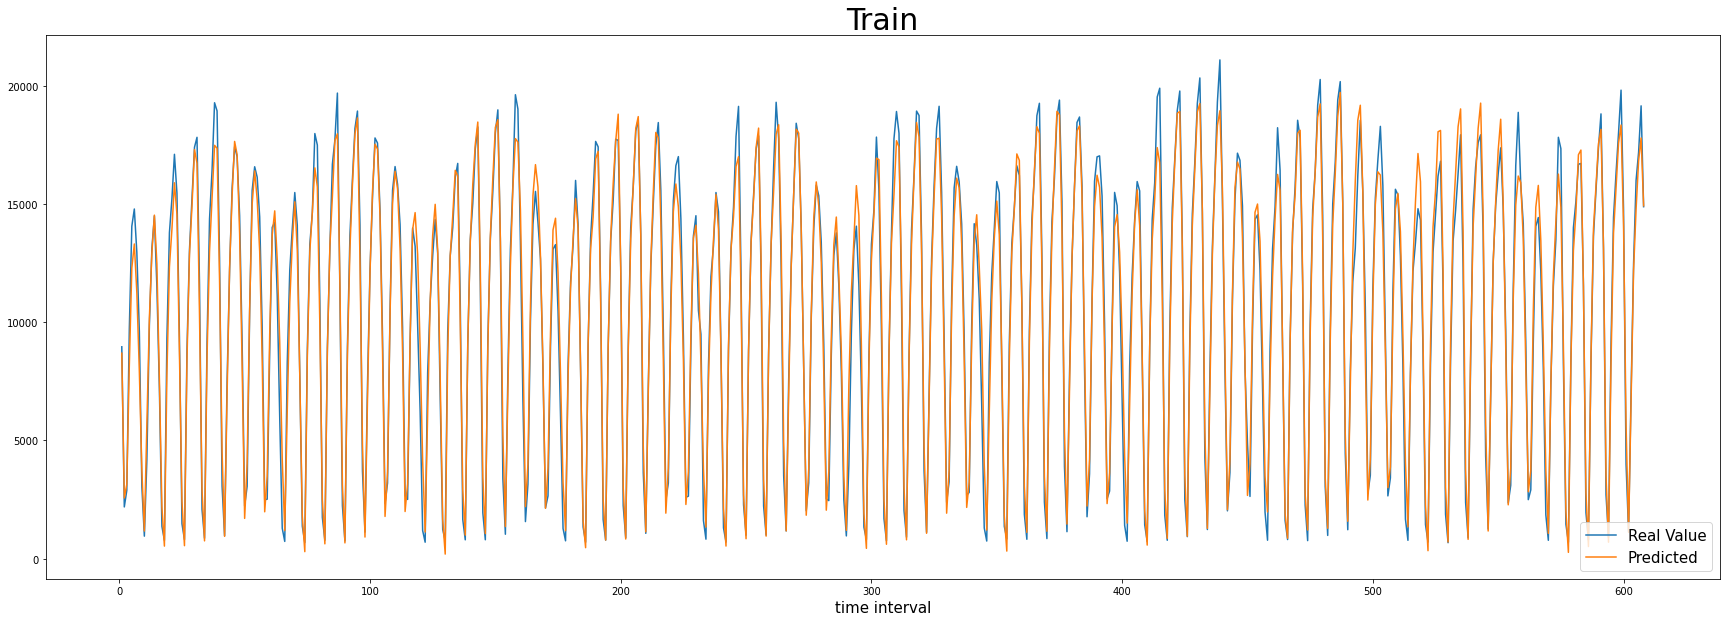

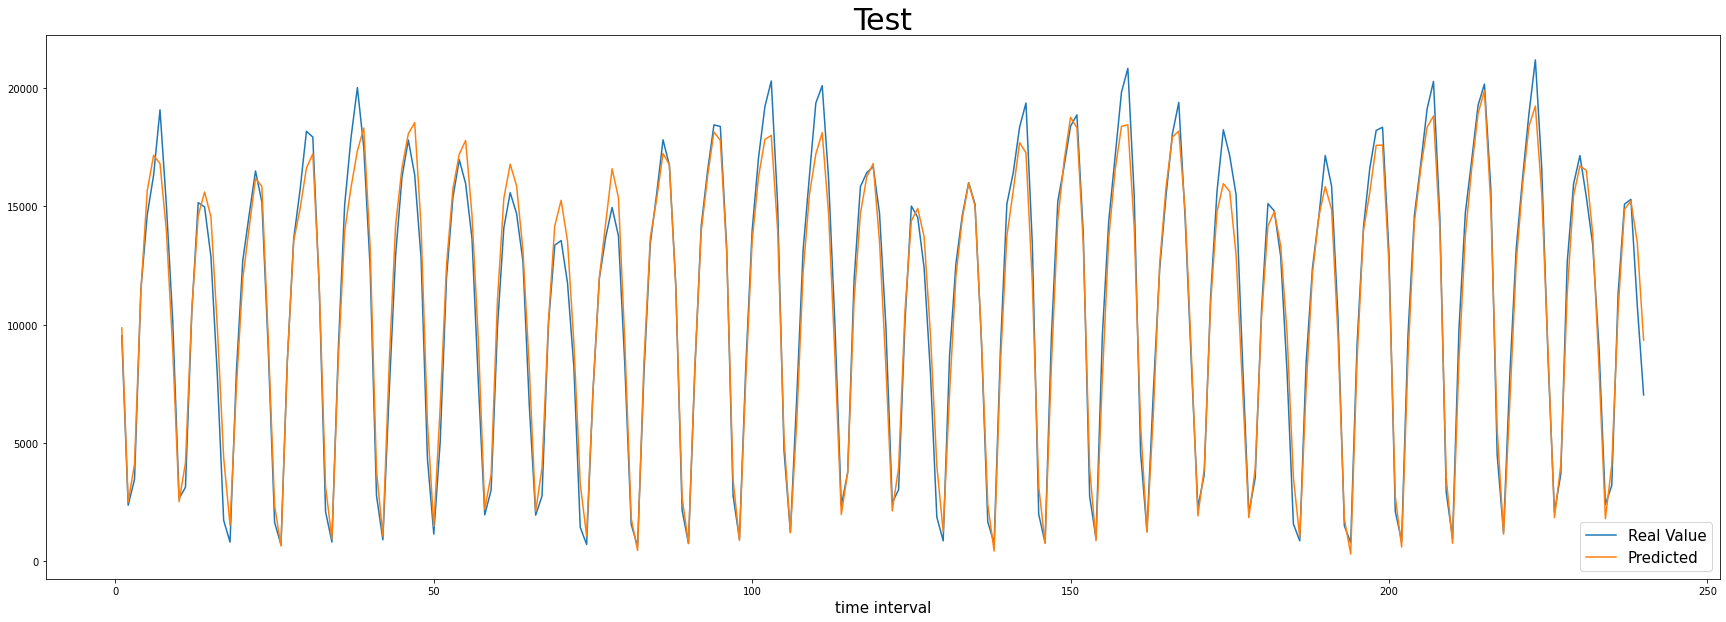

In [20]:
prediction_visualization(train_df, test_df, train_prediction_df, test_prediction_df)

### Evaluation

In [21]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [22]:
def evaluation(model_name, train_data, test_data, train_prediction_df, test_prediction_df):
    print(f'{model_name} train scores:')

    evaluate(mean_absolute_error, 'MAE', train_data['Demand'], train_prediction_df)
    evaluate(mean_squared_error, 'MSE', train_data['Demand'], train_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', train_data['Demand'], train_prediction_df)

    print(f'\n{model_name} test scores:')

    evaluate(mean_absolute_error, 'MAE', test_data['Demand'], test_prediction_df)
    evaluate(mean_squared_error, 'MSE', test_data['Demand'], test_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', test_data['Demand'], test_prediction_df)


In [23]:
evaluation('Ridge Regression', train_df, test_df, train_prediction_df, test_prediction_df)

Ridge Regression train scores:
MAE : 2.3262516677384943
MSE : 13.422051775340005
MAPE : 685859104687265.0

Ridge Regression test scores:
MAE : 2.381293126273346
MSE : 14.041319718052188
MAPE : 641744952444080.0


# File Saving

In [24]:
def save_predictions(dataset, path):
    dataset.to_parquet(path, index=False)

In [25]:
def prediction_labeling(pred_df, labeled_df):
    pred_df = pd.DataFrame(pred_df, columns = ['Predicted_demand'])
    labeled_df.reset_index(inplace = True)
    labeled_prediction_df = labeled_df[['PULocation', 'Date', 'DOLocation','Hour_interval']]
    labeled_prediction_df['Predicted_demand'] = pred_df
    return labeled_prediction_df

In [26]:
# def prediction_labeling(train_prediction_df, test_prediction_df, labeled_df):
#     train_prediction_df = pd.DataFrame(train_prediction_df, columns = ['Predicted_demand'])
#     test_prediction_df = pd.DataFrame(test_prediction_df, columns = ['Predicted_demand'])
#     pred_df = pd.concat([train_prediction_df,test_prediction_df],axis=0).reset_index(drop=True)
#     labeled_df.reset_index(inplace = True)
#     labeled_prediction_df = labeled_df[['Location', 'Date','Hour_interval']]
#     labeled_prediction_df['Predicted_demand'] = pred_df
#     return labeled_prediction_df

In [27]:
labeled_test_prediction_df = prediction_labeling(test_prediction_df, test_df)
labeled_train_prediction_df = prediction_labeling(train_prediction_df, train_df)

C:\Users\NPC\AppData\Local\Temp\ipykernel_17828\599915624.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_prediction_df['Predicted_demand'] = pred_df
C:\Users\NPC\AppData\Local\Temp\ipykernel_17828\599915624.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_prediction_df['Predicted_demand'] = pred_df


In [28]:
print(f'labeled prediction dataframe shape : {labeled_test_prediction_df.shape}')
labeled_test_prediction_df.head()

labeled prediction dataframe shape : (346320, 5)


,PULocation,Date,DOLocation,Hour_interval,Predicted_demand
0,13,2023-04-01,68,0,-0.266097
1,13,2023-04-01,68,3,0.630272
2,13,2023-04-01,68,6,1.466151
3,13,2023-04-01,68,9,3.924143
4,13,2023-04-01,68,12,4.410310


In [29]:
print(f'labeled prediction dataframe shape : {labeled_train_prediction_df.shape}')
labeled_train_prediction_df.head()

labeled prediction dataframe shape : (877344, 5)


,PULocation,Date,DOLocation,Hour_interval,Predicted_demand
0,13,2023-01-15,68,0,0.452805
1,13,2023-01-15,68,3,-0.161099
2,13,2023-01-15,68,6,1.197199
3,13,2023-01-15,68,9,2.756631
4,13,2023-01-15,68,12,4.651758


In [31]:
save_predictions(labeled_train_prediction_df, OUTPUT_PATH_TRAIN)
save_predictions(labeled_test_prediction_df, OUTPUT_PATH_TEST)